In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from math import sqrt

'''delete warning message'''

import warnings
warnings.filterwarnings('ignore')


In [2]:
temperature_city = pd.read_csv("/Users/antoniobaio/Desktop/Progetti/ProgettiDS/statsmodel/Time Series/ClimateChange/dataset/GlobalLandTemperaturesByCity.csv")

def convert_coordinates(coord):
    direction = coord[-1]
    degrees = float(coord[:-1])
    if direction in ['S', 'W']:
        degrees = -degrees
    return degrees

In [3]:
ancona = temperature_city.loc[temperature_city['City'] == 'Ancona', ['dt', 'AverageTemperature']]
ancona['dt'] = pd.to_datetime(ancona['dt'])
ancona.columns = ['Date', 'Temp']
ancona.reset_index(drop=True, inplace=True)
ancona = ancona.set_index('Date')

ancona = ancona.loc['1900-01-01':'2013-01-01']
ancona = ancona.asfreq('M', method='bfill')

ancona

,Temp
Date,
1900-01-31,8.726
1900-02-28,6.597
1900-03-31,10.365
1900-04-30,15.239
1900-05-31,19.681
...,...
2012-08-31,20.726
2012-09-30,16.897
2012-10-31,14.156


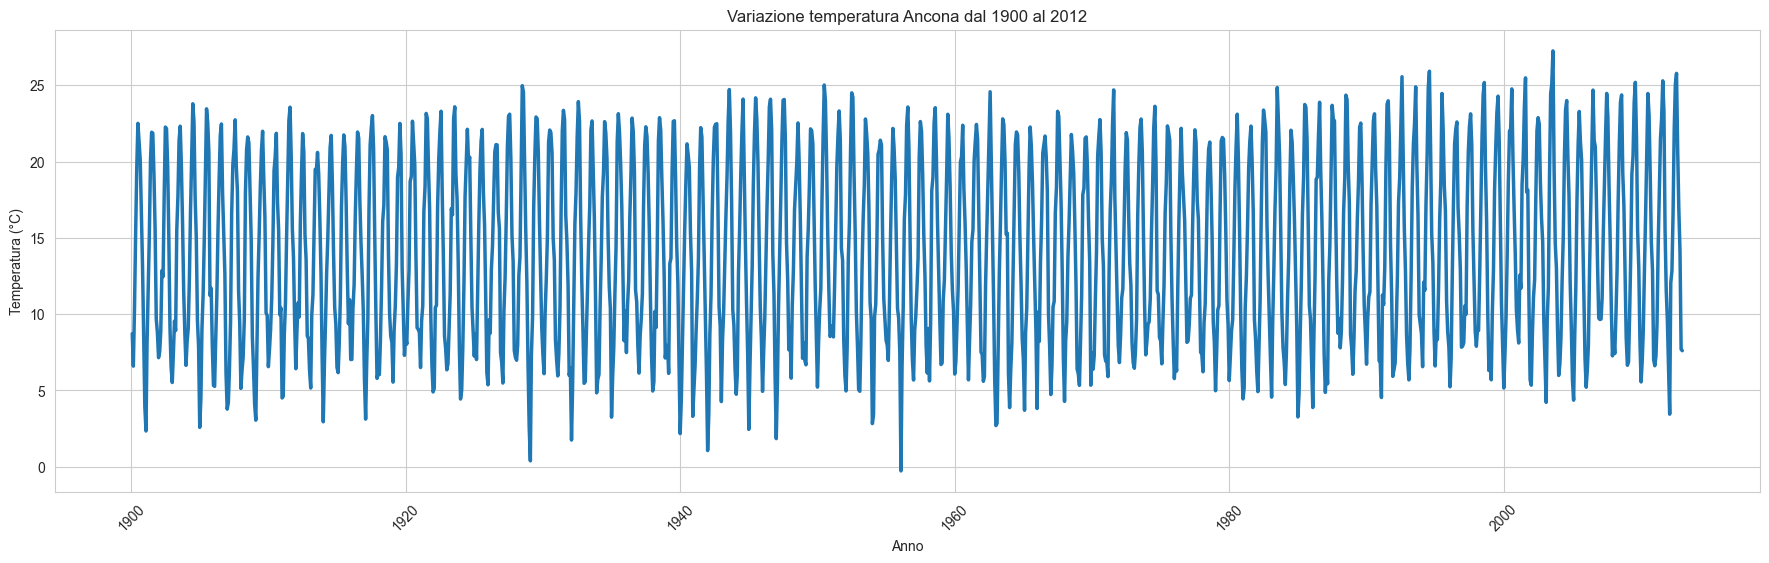

In [4]:
plt.figure(figsize=(22,6))
sns.set_style('whitegrid')
sns.lineplot(x=ancona.index, y=ancona['Temp'], linewidth=2.5)
plt.title('Variazione temperatura Ancona dal 1900 al 2012')
plt.xlabel('Anno')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)
plt.show()

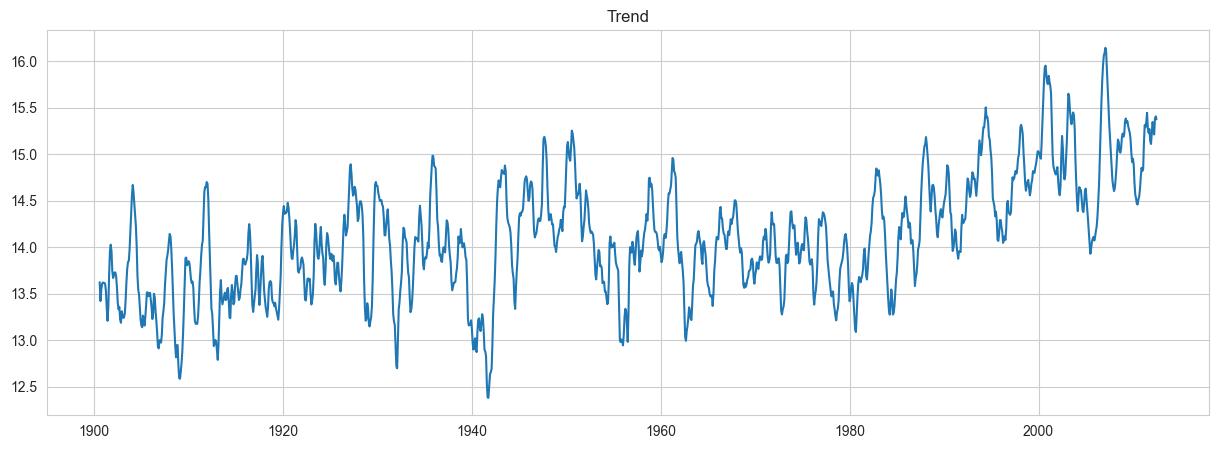

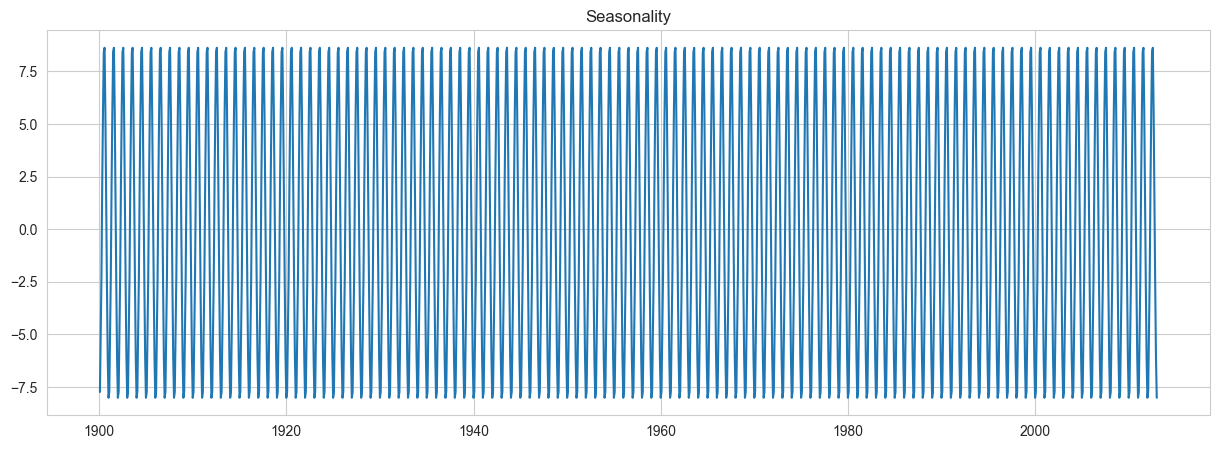

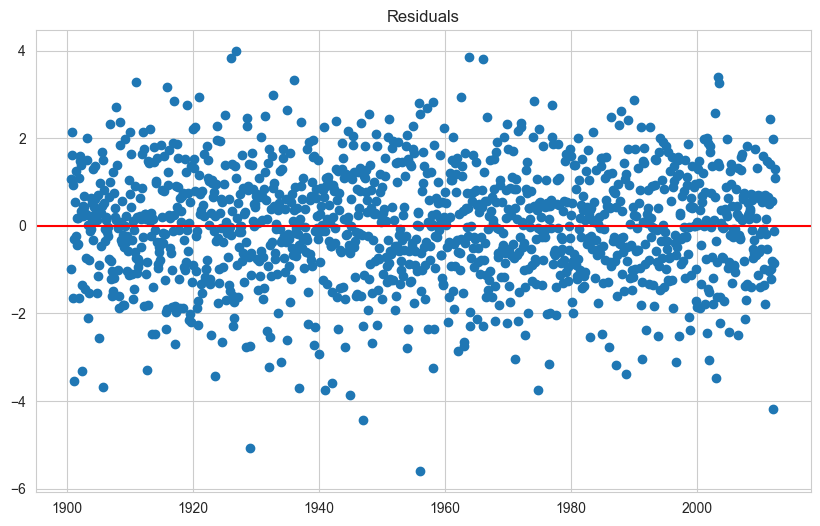

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposizione additiva della serie
decomposition = seasonal_decompose(ancona['Temp'], model='additive')

# Grafico del trend
plt.figure(figsize=(15,5))
plt.plot(decomposition.trend)
plt.title('Trend')
plt.show()

# Grafico della stagionalità
plt.figure(figsize=(15,5))
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.show()

# Grafico dei residui
plt.figure(figsize=(10,6))
plt.scatter(decomposition.resid.index, decomposition.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals')
plt.show()

Trend: passa da una media di circa 13.5 gradi annuali ad una media di circa 14.5 gradi annuali. La temperatura media è aumentata di circa 1 grado in 100 anni.

Stagionalità: la temperatura media è più alta in estate e più bassa in inverno. Questo è coerente con l'emisfero nord, dove si trova Ancona.

Residui: i residui sono distribuiti in modo normale intorno a zero, con una deviazione standard di circa 4 gradi. Se guardiamo attentamente ai residui della decomposizione additiva possiamo ancora intravedere la presenza di alcuni pattern, e tra l'altro sono distribuiti in modo uniforme.

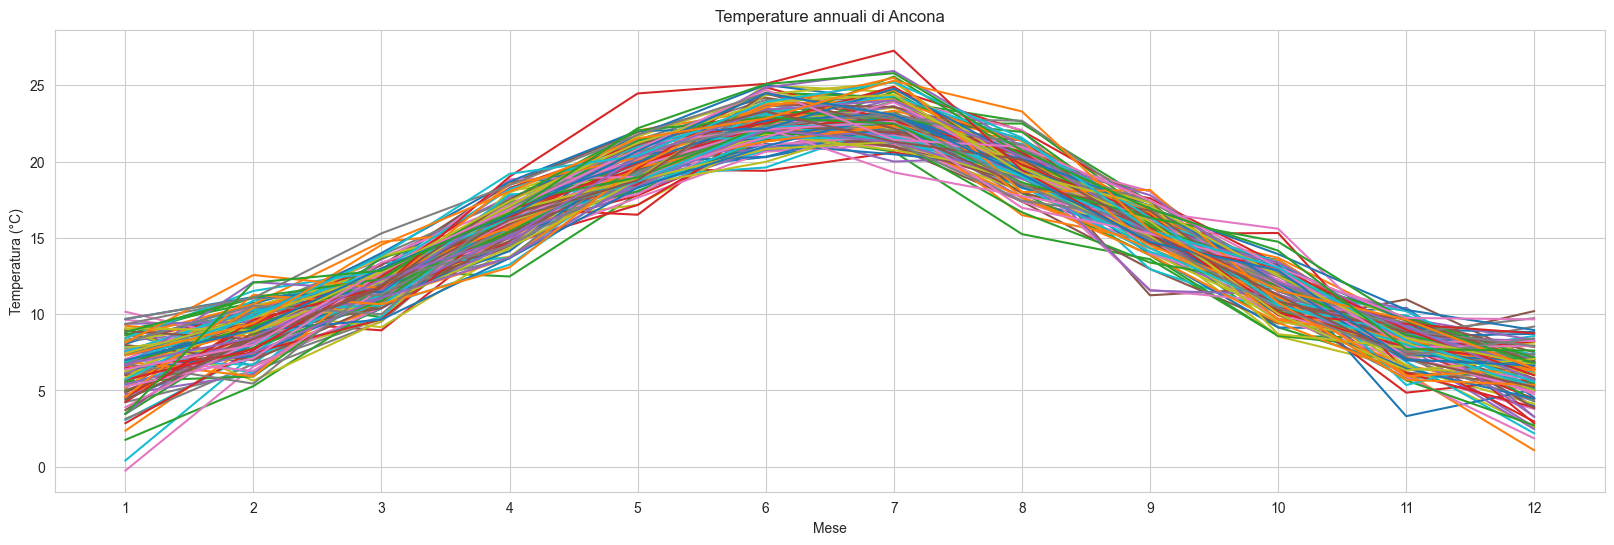

In [6]:
ancona['month'] = ancona.index.month
ancona['year'] = ancona.index.year

pivot = ancona.pivot_table(values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Temperature annuali di Ancona')
plt.xlabel('Mese')
plt.ylabel('Temperatura (°C)')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

La serie presenta chiaramente una certa stagionalità: le temperature più elevate si registrano tra aprile e settembre e quelle più basse tra ottobre e marzo. Per chiarificare le cose, unirò queste linee in un'unica linea, facendo la media dei livelli mensili:

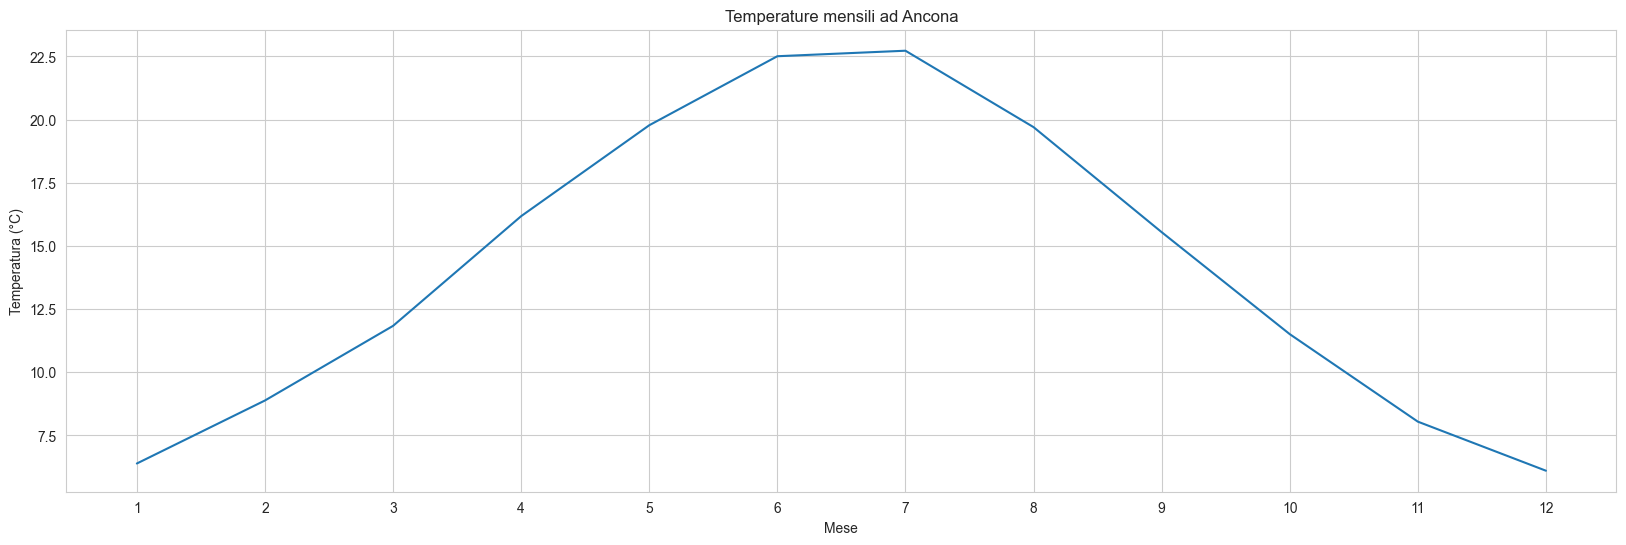

In [11]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Temperature mensili ad Ancona')
plt.xlabel('Mese')
plt.ylabel('Temperatura (°C)')
plt.xticks([x for x in range(1,13)])
plt.show()

La media mobile (MA) è una tecnica di analisi delle serie temporali che prevede di calcolare la media di un determinato numero di osservazioni consecutive in una serie.

L'idea è quella di usare una finestra mobile di dimensione fissa per calcolare la media di una porzione di dati e poi spostare la finestra lungo la serie, in modo da avere un valore di media mobile per ogni punto della serie.

La media mobile può essere utile per "smussare" la serie e identificare eventuali trend o variazioni stagionali. La MA è spesso utilizzata in combinazione con l'analisi di altri indicatori tecnici, come ad esempio l'oscillatore stocastico, il Relative Strength Index (RSI) o le bande di Bollinger.

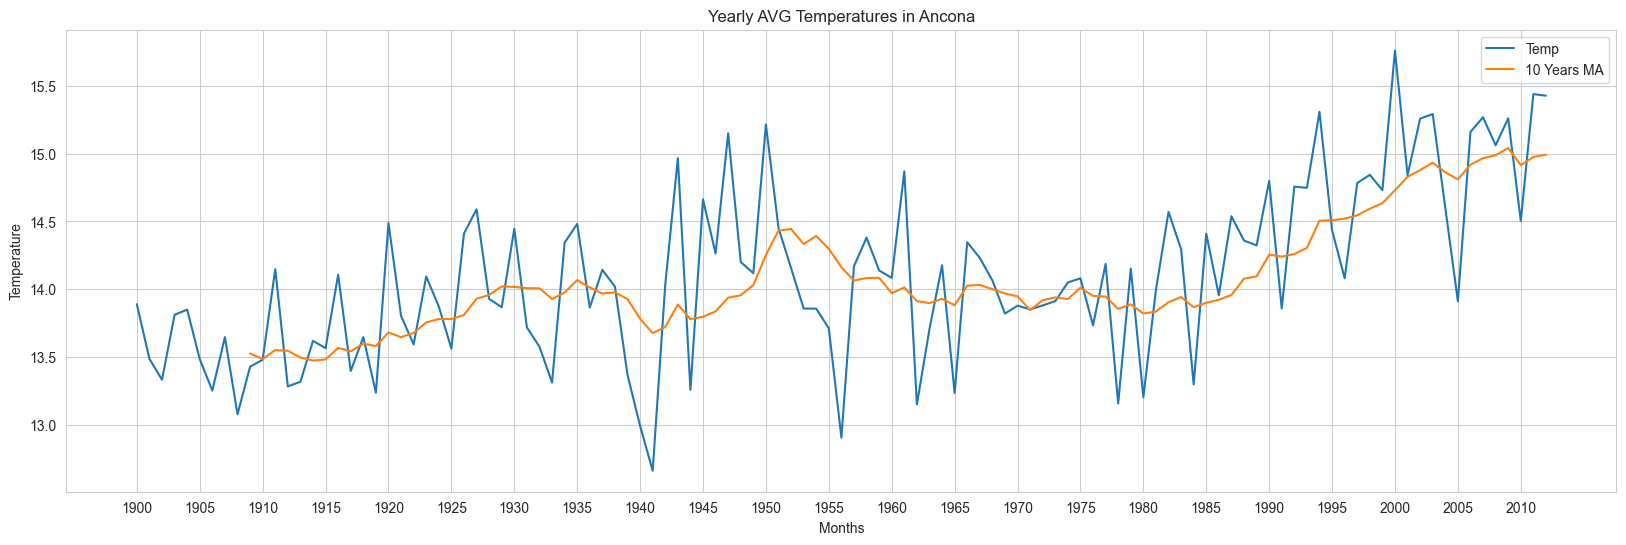

In [14]:
'''Trend annuali '''

yearly_trend = pd.pivot_table(ancona, values='Temp', index='year', aggfunc='mean')
yearly_trend['10 Years MA'] = yearly_trend['Temp'].rolling(10).mean()
yearly_trend[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Temperature medie annue ad Ancona')
plt.xlabel('Mesi')
plt.ylabel('Temperatura (°C)')
plt.xticks([x for x in range(1900,2012,5)])
plt.show()

Il grafico rappresenta la media annuale delle temperature a Ancona, confrontando la temperatura media annuale (linea blu) con la media mobile su una finestra di 10 anni (linea arancione). La linea blu rappresenta la temperatura media annuale di Ancona per ogni anno dal 1900 al 2011, mentre la linea arancione rappresenta la media mobile calcolata sulla finestra mobile di 10 anni di quella stessa temperatura media annuale.

La media mobile è stata utilizzata per cercare di vedere meglio la tendenza generale del riscaldamento globale. In particolare, la media mobile permette di "smussare" le fluttuazioni annuali della temperatura, fornendo una visione più chiara della tendenza generale, se questa esiste.

Nel grafico, possiamo notare che la linea arancione (media mobile) mostra una tendenza al rialzo, indicando un aumento della temperatura media annuale di Ancona nel corso degli anni.

Ci possono essere diverse ragioni per cui la media mobile tra il 1938 e il 1942 a Ancona è in discesa rispetto agli anni precedenti e successivi. Una possibile spiegazione potrebbe essere l'effetto della Seconda Guerra Mondiale, che iniziò nel settembre 1939 e coinvolse l'Italia dal giugno 1940. Durante la guerra, molte attività economiche e agricole furono sospese o interrotte, il che potrebbe aver avuto un impatto sulla temperatura media. Inoltre, l'uso di carburanti fossili e l'inquinamento atmosferico generato dalla guerra potrebbero aver influenzato la temperatura. Tuttavia, senza ulteriori analisi e dati, queste sono solo ipotesi e non possono essere confermate con certezza.

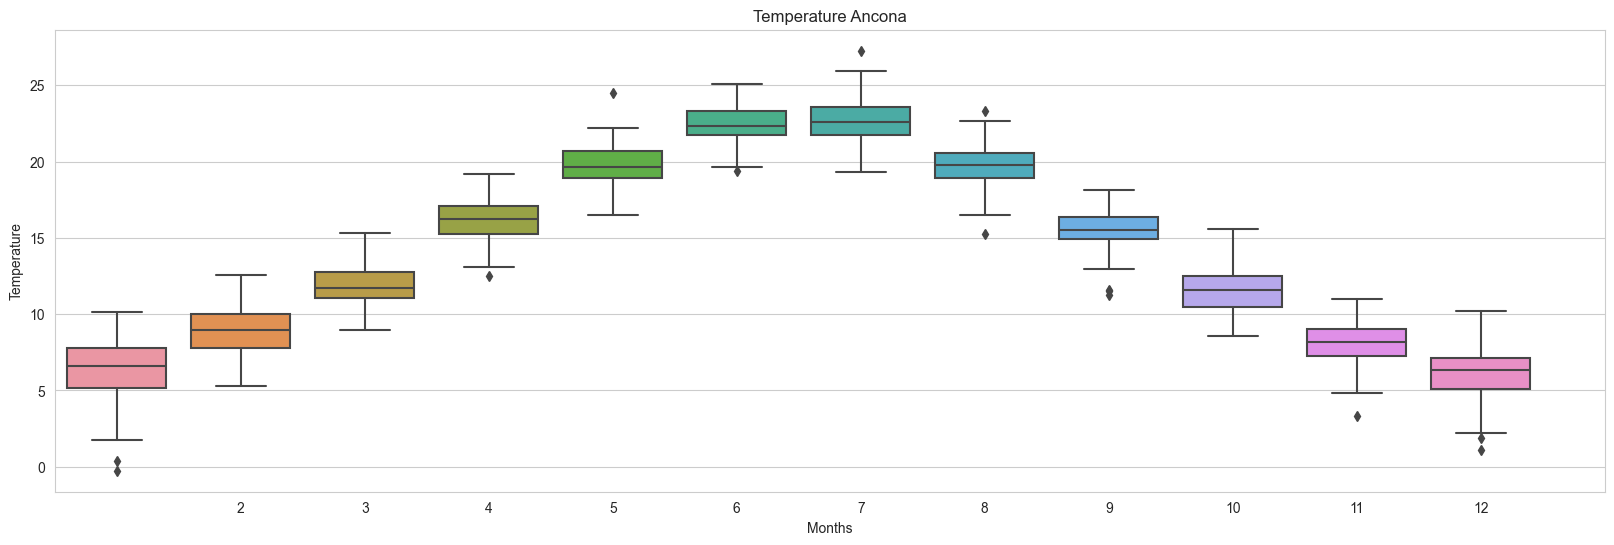

In [17]:
'''BoxPlot'''

plt.figure(figsize=(20,6))
sns.boxplot(x='month', y='Temp', data=ancona)
plt.title('Temperature Ancona')
plt.xlabel('Mese')
plt.ylabel('Temperatura (°C)')
plt.xticks([x for x in range(1,13)])
plt.show()


Possiamo confermare che c'è una tendenza costante all'aumento e che la temperatura media è aumentata da 13,5º a 15º, ovvero dell'11,11% in oltre 100 anni.

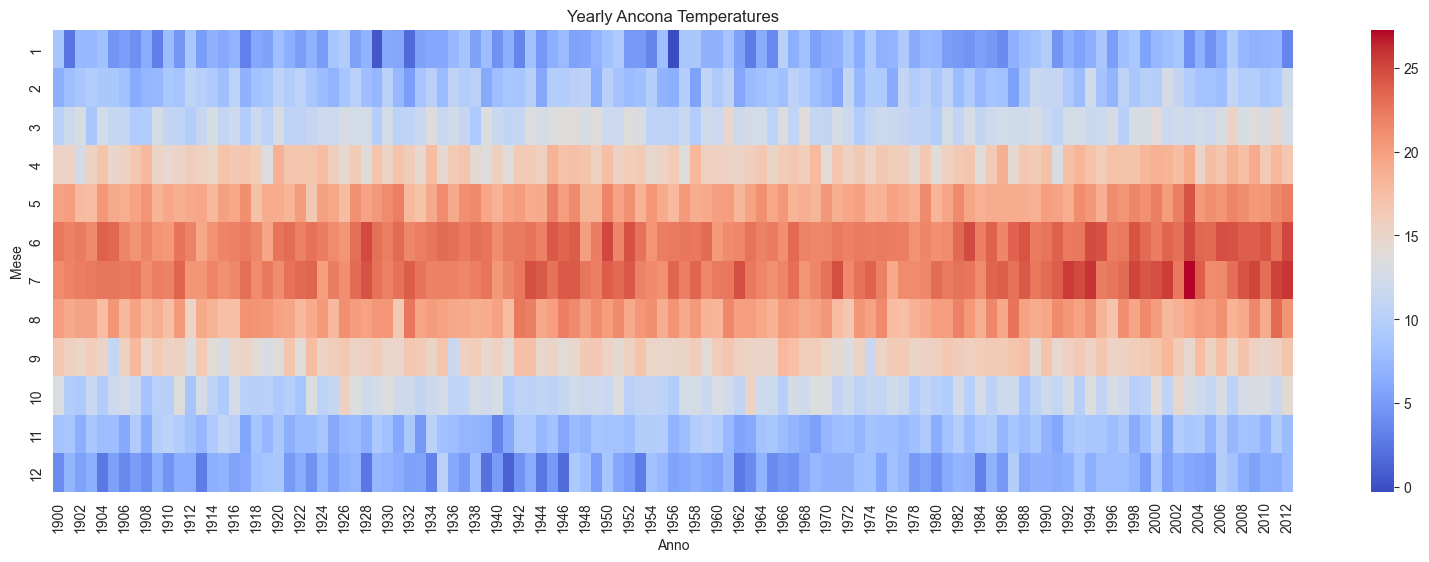

In [16]:
'''HeatMap'''

plt.figure(figsize=(20,6))
sns.heatmap(pivot, cmap='coolwarm')
plt.title('Temperature annuali Ancona')
plt.xlabel('Anno')
plt.ylabel('Mese')
plt.show()

Prima di procedere, divido i dati in set di addestramento, convalida e test. Dopo aver addestrato il modello, utilizzerò gli ultimi 5 anni per effettuare la convalida e il test dei dati, essendo 48 mesi per effettuare una convalida mese per mese (walk forward) e 12 mesi per effettuare un'estrapolazione per il futuro e confrontarla con il set di test:

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

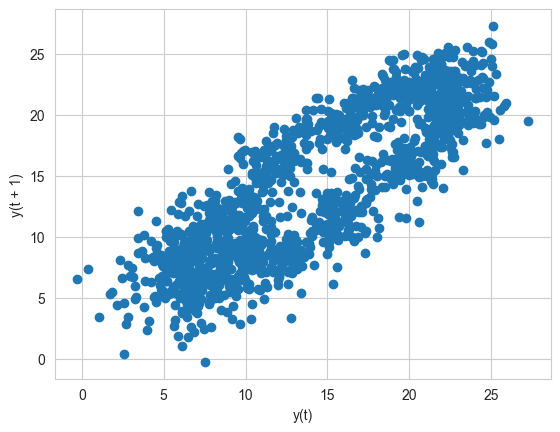

In [ ]:
'''Lag Plot'''
from pandas.plotting import lag_plot

lag_plot(ancona['Temp'], lag=1)

Creare un lag plot ci consente di verificare la randomaticità. I dati random si diffonderanno piuttosto uniformemente sia in orizzontale che in verticale. Se non è possibile vedere un pattern nel grafo, i dati saranno probabilmente random. D’altra parte, una forma o trend nel grafo (ad esempio, un pattern lineare) indica che i dati non sono random.

I plot random indicano che non c’è alcuna autocorrelazione; la conoscenza del valore di Yi-1 non ci aiuta in alcun modo a predire il valore di Yi.

La presenza di un pattern lineare nei dati suggerisce che è presente una forma di autocorrelazione. Un trend lineare positivo (ovvero crescente andando da sinistra a destra) è indice di un’autocorrelazione positiva. Un trend lineare negativo (ovvero decrescente andando da sinistra a destra) è indice di un’autocorrelazione negativa.

Più stretti sono i dati attorno alla diagonale e più forte è l’autocorrelazione. Dati perfettamente autocorrelati si troverebbero lungo una singola diagonale.

Divido il dataset in questo modo:
- Training set: ultimi 60 mesi, quindi 5 anni
- Validation set: 48 mesi, quindi 4 anni
- Test set: 12 mesi, quindi 1 anno

In [7]:
train = ancona[:-60].copy()
val = ancona[-60:-12].copy()
test = ancona[-12:].copy()

In [8]:
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29     7.422
2008-03-31     9.779
2008-04-30    12.749
2008-05-31    17.401
2008-06-30    21.212
Freq: M, Name: Temp, dtype: float64

In [9]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:, 0], baseline)
print(
    f'La RMSE della linea di base che cercheremo di diminuire è {round(rmse_base,4)} gradi celsius')


La RMSE della linea di base che cercheremo di diminuire è 3.525 gradi celsius


In [21]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Ancona Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nLa statistica del test è inferiore al valore critico del 5%. \nLa serie sembra essere stazionaria.')
    else:
        print("\nLa statistica del test è superiore al valore critico del 5%. \nLa serie non è stazionaria.")

# L'autocorrelazione (ACF) e l'autocorrelazione parziale (PACF)

L'autocorrelazione (ACF) e l'autocorrelazione parziale (PACF) sono strumenti di analisi statistica utilizzati per identificare le relazioni di dipendenza tra i valori di una serie temporale.

L'autocorrelazione (ACF) è una misura di quanto una serie temporale sia correlata con sé stessa in momenti di tempo diversi. In pratica, l'ACF calcola la correlazione tra la serie originale e una versione sfasata della stessa serie, a intervalli di tempo sempre maggiori. Ad esempio, l'ACF di ordine 1 (ACF lag 1) confronta la serie originale con la stessa serie sfasata di un periodo di tempo. L'ACF viene spesso rappresentata graficamente con un grafico a barre, in cui sull'asse x ci sono i diversi ritardi (o lags) e sull'asse y viene rappresentata la correlazione.

L'autocorrelazione parziale (PACF) invece cerca di eliminare l'effetto di eventuali correlazioni indirette. In pratica, l'ACF può essere influenzata da correlazioni indirette, ovvero da una correlazione tra la serie originale e la versione sfasata che è il risultato di una correlazione tra la serie originale e altre versioni sfasate. La PACF viene calcolata dopo aver eliminato l'effetto delle correlazioni indirette tramite l'analisi della correlazione tra la serie originale e la versione sfasata, tenendo conto dell'effetto di tutte le versioni sfasate intermedie.

Ad esempio, immaginiamo di avere una serie temporale che rappresenta le vendite mensili di un prodotto. L'ACF potrebbe mostrarci se le vendite di un mese sono correlate con quelle del mese precedente (lag 1), o di due mesi prima (lag 2), e così via. La PACF ci aiuta invece a capire se le vendite di un mese sono direttamente correlate con quelle del mese precedente, o se ci sono delle correlazioni indirette attraverso altri mesi interposti.



Results of Dickey-Fuller Test:
Test Statistic                   -4.0090
p-value                           0.0014
Lags Used                        23.0000
Number of Observations Used    1272.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

La statistica del test è inferiore al valore critico del 5%. 
La serie sembra essere stazionaria.


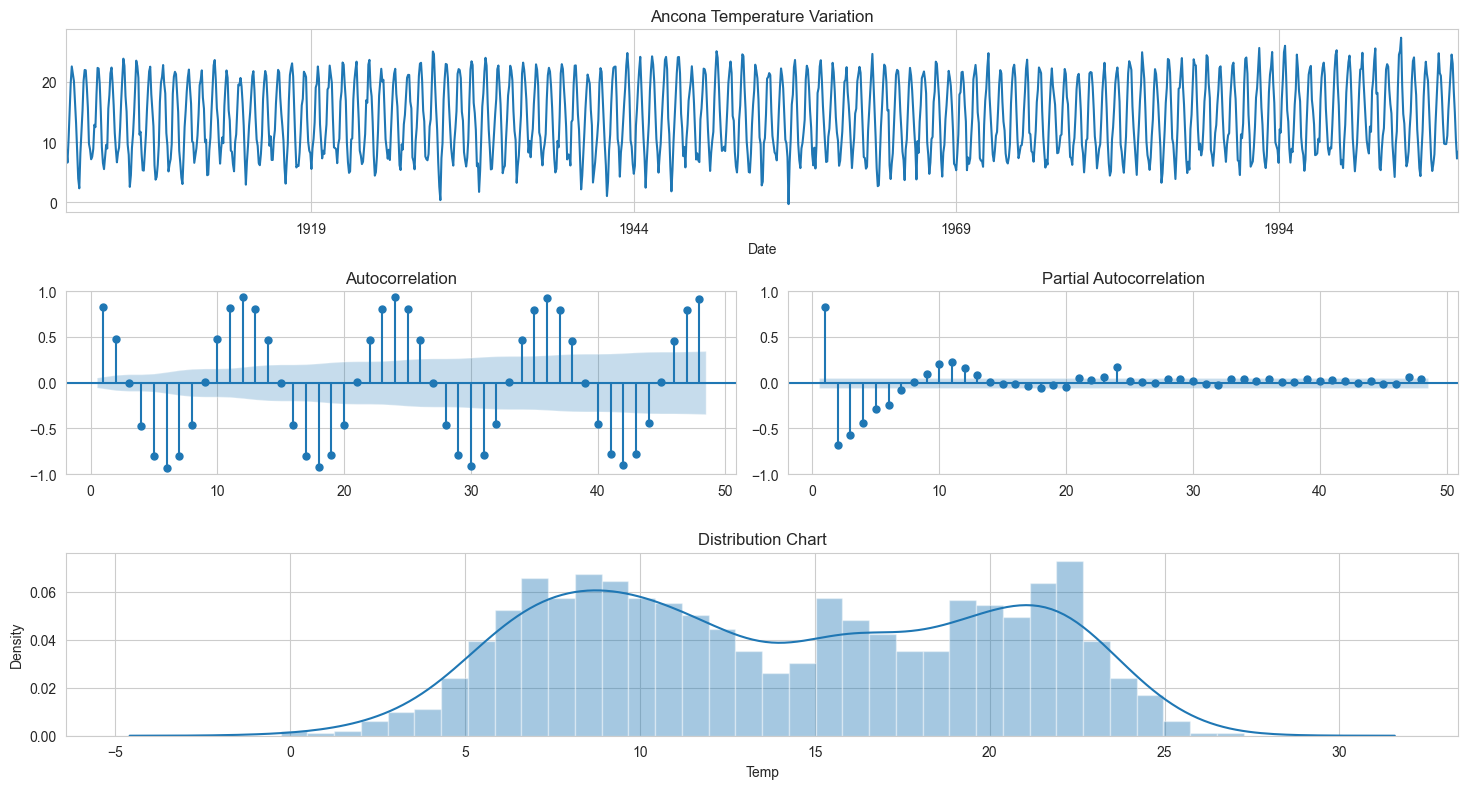

In [22]:
check_stationarity(train['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -13.3988
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1260.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

La statistica del test è inferiore al valore critico del 5%. 
La serie sembra essere stazionaria.


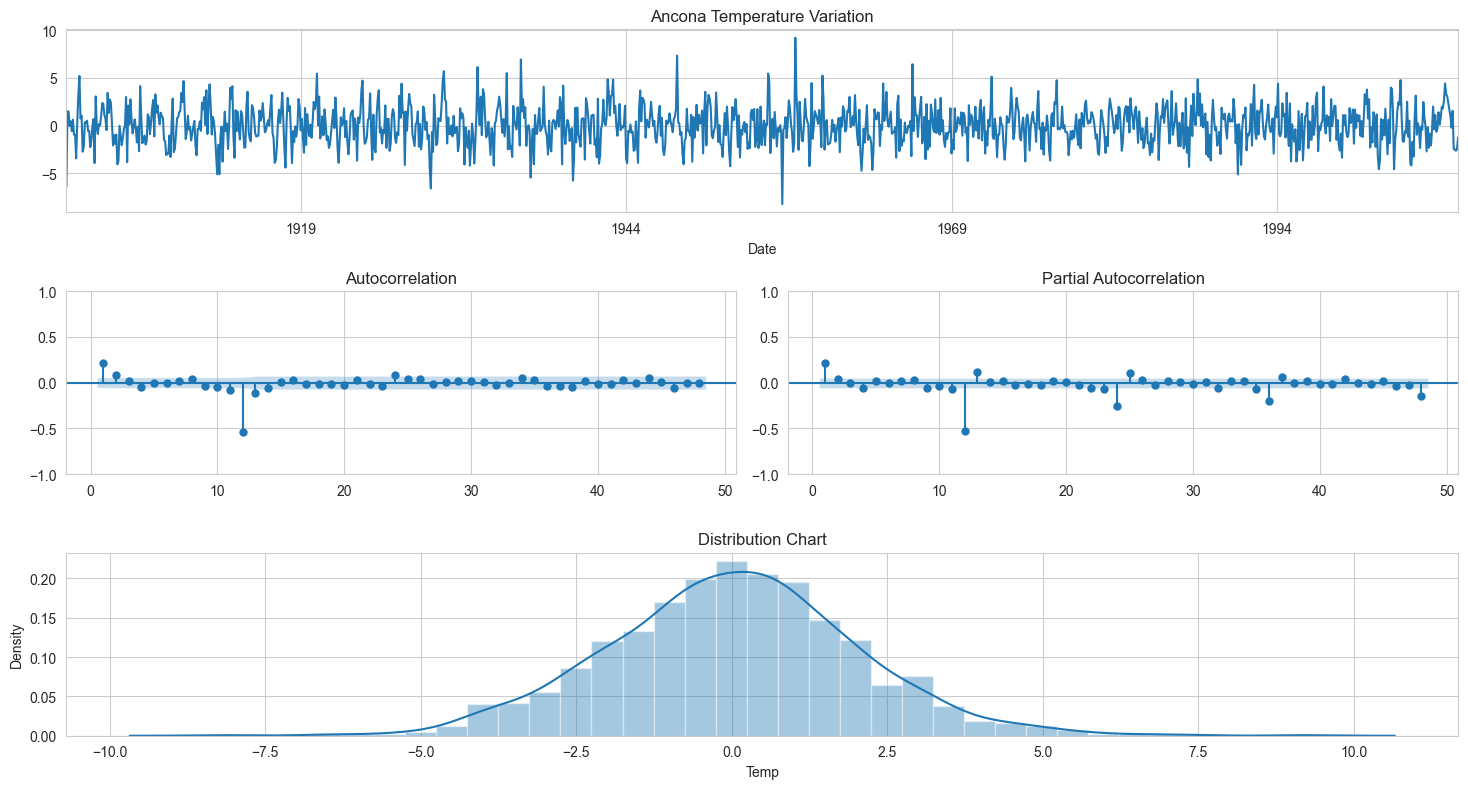

In [23]:
check_stationarity(train['Temp'].diff(12).dropna())

In questo metodo, il modello viene addestrato su una parte del dataset e la sua performance viene testata su una finestra temporale successiva.

La funzione prende in input tre argomenti: `training_set`, `validation_set` e `params`. `training_set` è un DataFrame contenente i dati di addestramento, `validation_set` è un DataFrame contenente i dati di validazione e `params` è una tupla contenente i parametri del modello SARIMA.

All'inizio della funzione viene creato un elenco di valori storici (`history`) in base ai dati di addestramento. La funzione poi itera attraverso il validation set e per ogni punto nel tempo addestra il modello SARIMA sulle osservazioni storiche usando i parametri specificati. Viene quindi effettuata una previsione per il punto successivo e la previsione viene aggiunta all'elenco `prediction`. Infine, viene aggiornato l'elenco `history` con l'ultima osservazione del validation set.

La funzione restituisce l'elenco delle previsioni `prediction`.

In [17]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

Secondo te dei valori PDQS di (0,1,1,12) sono giusti in questo caso?

In [33]:
'''val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((2,1,0),(0,1,1,12),'c'))'''

val = pd.read_csv("/Users/antoniobaio/Desktop/Progetti/ProgettiDS/statsmodel/Time Series/ClimateChange/test/val.csv")
val.head(10)

,Date,Temp,month,year,Pred
0,2008-01-31,7.422,1,2008,7.081311
1,2008-02-29,9.779,2,2008,9.768263
2,2008-03-31,12.749,3,2008,13.089320
3,2008-04-30,17.401,4,2008,17.109655
4,2008-05-31,21.212,5,2008,20.841819
5,2008-06-30,23.882,6,2008,23.762768
6,2008-07-31,24.377,7,2008,24.060329
7,2008-08-31,19.232,8,2008,21.263925
8,2008-09-30,17.097,9,2008,16.138887
9,2008-10-31,12.490,10,2008,12.545520


In [34]:
val['Date'] = pd.to_datetime(val['Date'])
val.reset_index(drop=True, inplace=True)
val = val.set_index('Date')
val.head(10)

,Temp,month,year,Pred
Date,,,,
2008-01-31,7.422,1,2008,7.081311
2008-02-29,9.779,2,2008,9.768263
2008-03-31,12.749,3,2008,13.089320
2008-04-30,17.401,4,2008,17.109655
2008-05-31,21.212,5,2008,20.841819
2008-06-30,23.882,6,2008,23.762768
2008-07-31,24.377,7,2008,24.060329
2008-08-31,19.232,8,2008,21.263925
2008-09-30,17.097,9,2008,16.138887


In [35]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"La RMSE del modello SARIMA(2,1,0),(0,1,1,12),'c' era {round(rmse_pred,4)} di celsius degrees")
print(f"Si tratta di una diminuzione di {round((rmse_pred/rmse_base-1)*100,2)}% nella RMSE")

La RMSE del modello SARIMA(2,1,0),(0,1,1,12),'c' era 1.0913 di celsius degrees
Si tratta di una diminuzione di -69.04% nella RMSE


In [36]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']
val.head(10)

,Temp,month,year,Pred,Error
Date,,,,,
2008-01-31,7.422,1,2008,7.081311,0.340689
2008-02-29,9.779,2,2008,9.768263,0.010737
2008-03-31,12.749,3,2008,13.089320,-0.340320
2008-04-30,17.401,4,2008,17.109655,0.291345
2008-05-31,21.212,5,2008,20.841819,0.370181
2008-06-30,23.882,6,2008,23.762768,0.119232
2008-07-31,24.377,7,2008,24.060329,0.316671
2008-08-31,19.232,8,2008,21.263925,-2.031925
2008-09-30,17.097,9,2008,16.138887,0.958113


In [38]:
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,7.422,7.081311,0.340689
2008-02-29,9.779,9.768263,0.010737
2008-03-31,12.749,13.089320,-0.340320
2008-04-30,17.401,17.109655,0.291345
2008-05-31,21.212,20.841819,0.370181


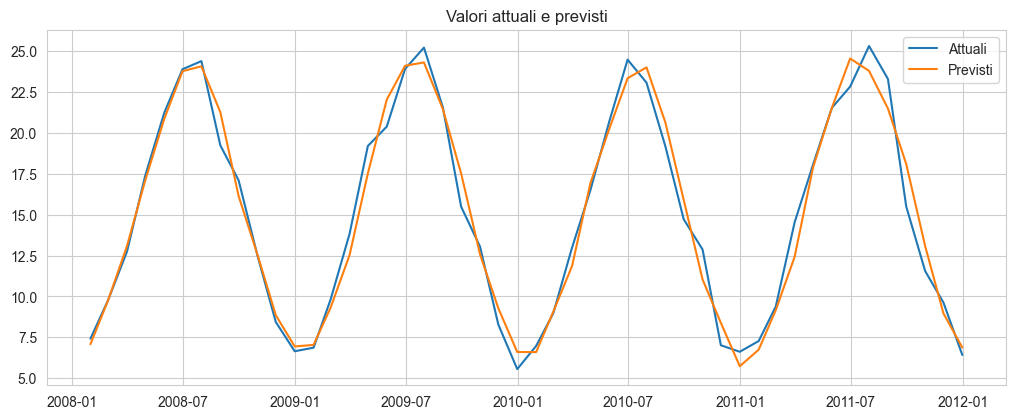

In [42]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot2grid((2, 2), (0, 0))

# Plotting the Current and Predicted values
ax1.plot(val.iloc[:, 0:2])
ax1.legend(['Attuali', 'Previsti'])
ax1.set_title('Valori attuali e previsti')

plt.tight_layout()
plt.show()


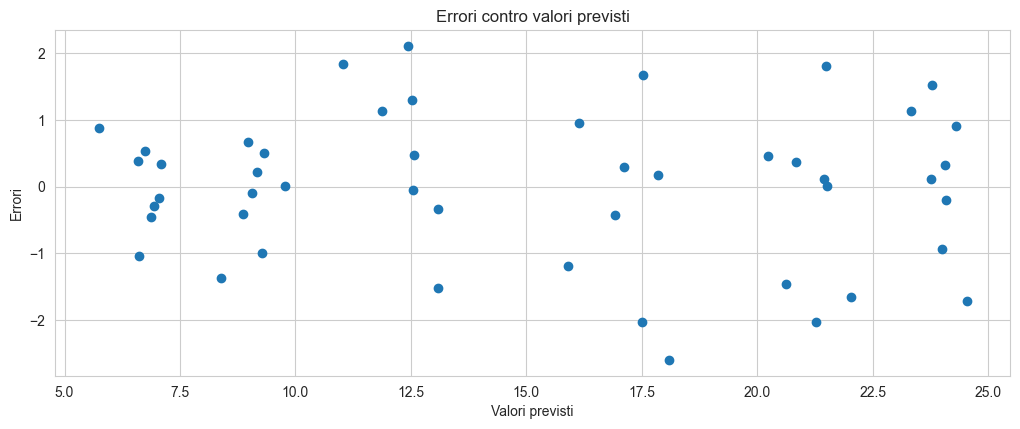

In [43]:
plt.figure(figsize=(20,8))
ax2 = plt.subplot2grid((2, 2), (0, 1))

# Residual vs Predicted values
ax2.scatter(val.iloc[:, 1], val.iloc[:, 2])
ax2.set_xlabel('Valori previsti')
ax2.set_ylabel('Errori')
ax2.set_title('Errori contro valori previsti')

plt.tight_layout()
plt.show()



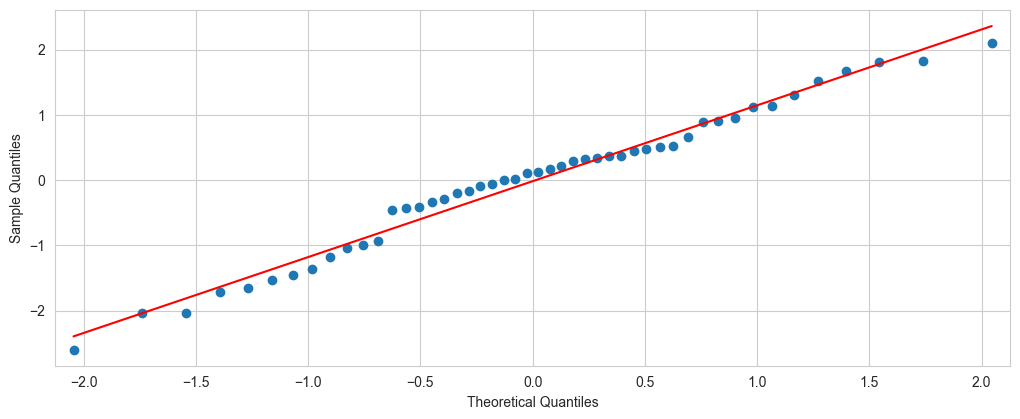

In [44]:
plt.figure(figsize=(20,8))
ax3 = plt.subplot2grid((2, 2), (1, 0))

# QQ Plot of the residual
sm.graphics.qqplot(val.iloc[:, 2], line='r', ax=ax3)
plt.tight_layout()
plt.show()

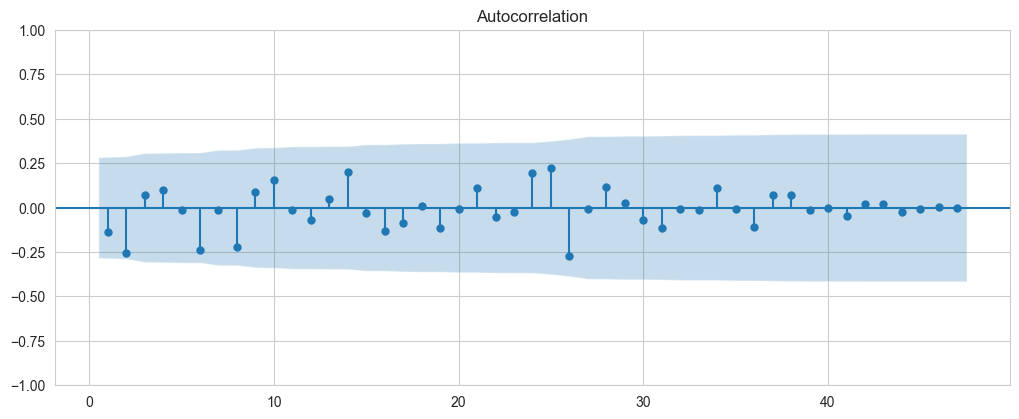

In [45]:
plt.figure(figsize=(20,8))
ax4 = plt.subplot2grid((2, 2), (1, 1))

# Autocorrelation plot of the residual
plot_acf(val.iloc[:, 2], lags=(len(val.iloc[:, 2])-1), zero=False, ax=ax4)
plt.tight_layout()
plt.show()


In [46]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1900-01-31     8.726
1900-02-28     6.597
1900-03-31    10.365
1900-04-30    15.239
1900-05-31    19.681
Name: Temp, dtype: float64

In [47]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(2,1,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [48]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

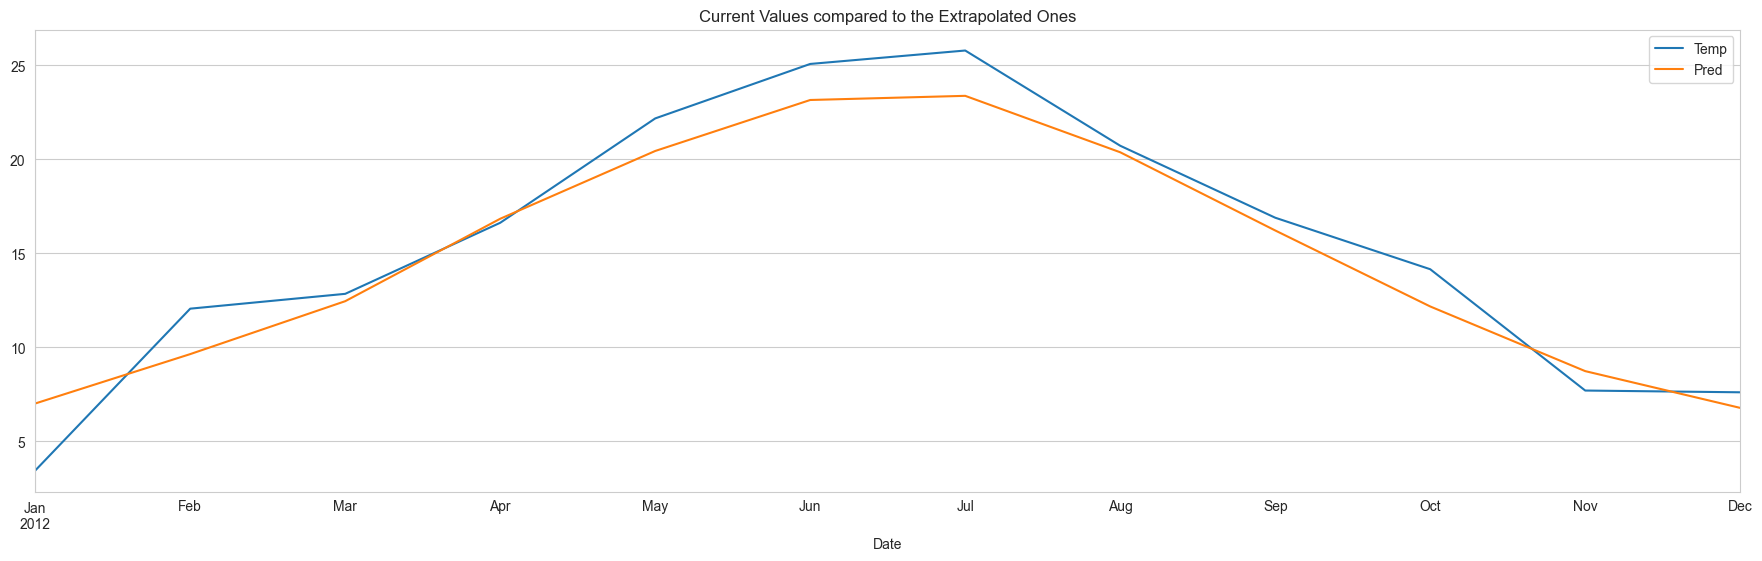

In [49]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Valori attuali rispetto a quelli estrapolati')
plt.show()

In [50]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 4.27 celsius degrees
The baseline RMSE for the test extrapolation was 1.77 celsius degrees
That is an improvement of 58.55%
